In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os
import datetime as dt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gs
from scipy.spatial import cKDTree

In [2]:
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['data_dir']

'/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy'

In [9]:
root = '/css/viirs/data/'

extent = [-125,-102,31,49.2] #western us
extent = [-124,-105,33.4,48.6] #western us slightly cropped to large fires

#swath names - Suomi-NPP, via ladsweb.modaps.eosdis.nasa.gov
with open('/home/scoffie1/links/VNP03IMG_0613-1130_2020.txt', 'r') as links:
    files = sorted(links.readlines())

lut = pd.read_csv('/home/scoffie1/pix_size_lut.csv', index_col='sample')

files[:4]

['/archive/allData/5200/VNP03IMG/2020/165/VNP03IMG.A2020165.0748.002.2021125190531.nc\n',
 '/archive/allData/5200/VNP03IMG/2020/165/VNP03IMG.A2020165.0754.002.2021125190531.nc\n',
 '/archive/allData/5200/VNP03IMG/2020/165/VNP03IMG.A2020165.0930.002.2021125190614.nc\n',
 '/archive/allData/5200/VNP03IMG/2020/165/VNP03IMG.A2020165.0936.002.2021125190627.nc\n']

In [30]:
files[1433] #error

'/archive/allData/5200/VNP03IMG/2020/300/VNP03IMG.A2020300.0900.002.2021126045858.nc\n'

In [ ]:
%%time

all_dets = pd.DataFrame()

for file in files[:21]:
    timestamp = file.split('.')[1:3]
    print(timestamp)
    year = timestamp[0][1:5]
    day = timestamp[0][5:8]
    time = timestamp[1]
    date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %d') 
    acq_date = dt.datetime.strptime(year+day, '%Y%j').strftime('%-m/%-d/%y') #match FIRMS
    daytime = int(time) > 1500 #timestamps in the 1900h-2200h UTC range are afternoon for Western US
    
    try:
        #get VNP03 geolocation
        matches = os.listdir(f'{root}/Level1/VNP03IMG.trimmed/{year}/{day}')
        matches = [match for match in matches if match[18:22] == time]
        geo = xr.open_dataset(f'{root}/Level1/VNP03IMG.trimmed/{year}/{day}/{matches[0]}', engine='netcdf4',group = 'geolocation_data')
        
        i, j = np.indices(geo.longitude.shape) #line and sample
        scene = ((geo.longitude > extent[0]) & (geo.longitude < extent[1]) & (geo.latitude > extent[2]) & (geo.latitude < extent[3])).values


        #get VNP14 fire mask + qa
        matches = os.listdir(f'{root}/Level2/VNP14IMG/{year}/{day}')
        matches = [match for match in matches if match[18:22]==time]
        data = xr.open_dataset(f'{root}/Level2/VNP14IMG/{year}/{day}/{matches[0]}', engine='netcdf4')

        qa = data['algorithm QA']
        fire = data['fire mask']
        daynight = data.DayNightFlag #string Day or Night

        m13b = data.variables['FP_MeanRad13'][:]
        lonfp = data.variables['FP_longitude'][:]
        latfp = data.variables['FP_latitude'][:]
        frp = data.variables['FP_power'][:]

        tree = cKDTree(np.array([lonfp, latfp]).T) #search tree for finding nearest m13b

        fires = (fire>6).values

        #get VNP02MOD M13 data (for FRP calc)
        
        matches = os.listdir(f'{root}/Level1/VNP02MOD/{year}/{day}')
        matches = [match for match in matches if '.'.join(timestamp) in match]
        data750 = xr.open_dataset(f'{root}/Level1/VNP02MOD/{year}/{day}/{matches[0]}', engine='netcdf4', group='observation_data')
        m13 = data750['M13'][:]
        
    except:
        print('error with file',file) #a few files are broken
        continue

    #candidate extraction -------------------------------------------
    
    scene_qa = qa.values[scene]
    values, counts = np.unique(scene_qa, return_counts=True)

    table = pd.DataFrame(index = values, columns=range(22,-1,-1)) #[22,21,...1]
    for i1 in table.index:
        b = np.binary_repr(i1, width=23)
        b = [int(s) for s in b]
        table.loc[i1, :] = b
    
    #report back all the pixels that have an 8 or 10 ~ background or candidate fires
    keep = table[(table.loc[:,8]==1) | (table.loc[:,10]==1)].index
    keep = (np.isin(qa[:], keep) | (fires)) & (scene) #"fires" because some low conf are Test 16 pixel saturation
    
    if keep.sum()==0:
        print('no dets')
        continue #skip ahead if no detections
    
    #build pandas table for exporting, following VIIRS L2 columns
    i_dets = pd.DataFrame() #copy for this swath
    i_dets['longitude'] = list(geo.longitude.values[keep])
    i_dets['latitude'] = list(geo.latitude.values[keep])
    i_dets['fire_mask'] = list(fire.values[keep])
    i_dets['daynight'] = daynight[0]
    i_dets['confidence'] = i_dets.fire_mask
    i_dets.confidence = i_dets.confidence.replace({0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
    i_dets['acq_date'] = acq_date
    i_dets['acq_time'] = time
    i_dets['j'] = list(j[keep]) #sample number for pixel size lookup
    
    
    #FRP calculation ---------------------------------------------
    
    #colocation to 750m 
    i, j = i//2, j//2
    i_dets['i750'] = list(i[keep])
    i_dets['j750'] = list(j[keep])
    
    #first loop through known dets to match up original "old frp"
    known = i_dets[i_dets.confidence!='x']
    for k in known.index:
        dist, nearest = tree.query([ known.loc[k, 'longitude'], known.loc[k, 'latitude'] ])
        i_dets.loc[k, 'frp_old'] = frp[nearest]
    i_dets['frp'] = i_dets.frp_old #duplicate for completion. Some won't be changed
    
    #loop through all unique 750m pixels that have either a candidate or known det, calc FRP
    unique750 = i_dets.groupby(['i750','j750']).mean().reset_index()[['i750','j750']]
    for pixel in unique750.index:
        i750, j750 = unique750.loc[pixel, :]
        subpixels = i_dets[(i_dets.i750==i750) & (i_dets.j750==j750)] #between 1 and 4 pixels
        candidates = subpixels[subpixels.confidence=='x']
        known = subpixels[subpixels.confidence!='x']
        #print(len(candidates), 'candidates', len(known), 'known')
        if len(candidates) > 0:
            if len(known) > 0: #redistribute existing FRP
                i_frp = known.frp_old.mean()
                i_dets.loc[subpixels.index, 'frp'] = i_frp * len(known) / len(subpixels)
 
            else: #no known dets; calculate FRP for candidates using nearest M13 background & distribute
                #nearest m13b
                pixel = subpixels.iloc[0, :] #double use of pixel name?
                i_lon = pixel['longitude']
                i_lat = pixel['latitude']
                dist, nearest = tree.query([i_lon, i_lat])
                background = m13b[nearest]
                i_dets.loc[subpixels.index, 'dist_m13b'] = dist
                
                #pixel area
                scan_pos = pixel['j']
                area = lut.loc[scan_pos, 'pix_area'] * 4 #1e6 factor for m2 canceled by Watt->MegaWatt
                
                #frp calculation
                i_m13 = m13[pixel.i750, pixel.j750]
                i_frp = area * 5.67e-8 * (i_m13 - background) / 2.88e-9
                i_dets.loc[subpixels.index, 'frp'] = i_frp / len(subpixels) 

    all_dets = pd.concat([all_dets, i_dets])

    if int(day)%50==0: all_dets.to_csv(f'/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_{day}.csv', index=False)

all_dets.to_csv(f'/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_{day}.csv', index=False)
print('done')

In [30]:
data1 = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_166.csv')
data2 = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_335.csv')
data3 = pd.concat([data1,data2])
data3 = data3[(data3.longitude>extent[0]) & (data3.longitude<extent[1])  &(data3.latitude>extent[2]) & (data3.latitude<extent[3])]
data3.to_csv(f'/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP.csv', index=False)

In [31]:
all_dets = data3

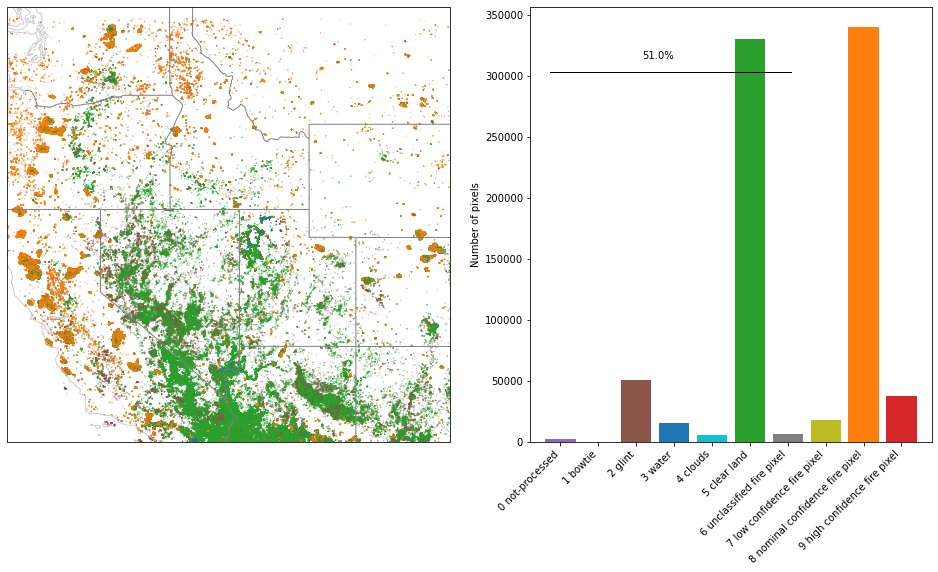

In [34]:
#plot

#define colormap for fire mask
newcolors = [mpl.colormaps['tab10'](c) for c in [4,6,5,0,9,2,7,8,1,3]]
#newcolors = [mpl.colormaps['tab10'](c) for c in [9,9,9,9,9,9,9,3,3,3]] #just old vs new dets
newcmp = ListedColormap(newcolors)

#map (left) + bars (right) for all 2019 ---------------------------------------
fig = plt.figure(figsize=(18,8))
grid = gs.GridSpec(1,2, width_ratios=[3,2])
ax = plt.subplot(grid[0], projection = ccrs.Miller())
ax2 = plt.subplot(grid[1])

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.set_extent([-124,-105,33.4,48.6])
ax.add_feature(cfeature.BORDERS, edgecolor='0.8')
ax.add_feature(cfeature.COASTLINE, edgecolor='0.8')
ax.add_feature(states_provinces, edgecolor='gray')
ax.scatter(all_dets.longitude, all_dets.latitude, c=newcmp(all_dets.fire_mask.astype(int)), s=0.05, transform=ccrs.Geodetic(), cmap=newcmp)

#right panel barchart
values, counts = np.unique(all_dets['fire_mask'], return_counts=True)
fraction_missing = counts[values<7].sum() / counts.sum()
colors = [newcmp(c) for c in values]
ax2.bar(values, counts, color=colors)
labels = ['0 not-processed', '1 bowtie', '2 glint', '3 water','4 clouds',
          '5 clear land','6 unclassified fire pixel','7 low confidence fire pixel',
          '8 nominal confidence fire pixel','9 high confidence fire pixel']
ax2.set_xlim((-0.8,9.8))
ax2.set_xticks(range(10))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Number of pixels')    
ax2.annotate('{:.1f}%'.format(fraction_missing*100), xy=(0.28, 0.88),  size=10, xycoords=ax2.transAxes)
ax2.plot((0.05,0.65), (0.85, 0.85), transform=ax2.transAxes, c='k', linewidth=1)

plt.subplots_adjust(wspace=0)
#plt.savefig('/home/scoffie1/figures/all_candidates.png', bbox_inches='tight', dpi=200)

In [40]:
data['fire mask'].legend

'\n0 not-processed (non-zero QF)\n1 bowtie\n2 glint\n3 water\n4 clouds\n5 clear land\n6 unclassified fire pixel\n7 low confidence fire pixel\n8 nominal confidence fire pixel\n9 high confidence fire pixel\n2n��U'

Next steps:<br>
Join function in QGIS to associate buffered FEDS perimeters with MTBS large fire names. <br>
Join detections within perimeters